# Progetto Machine Learning - Elia Perantoni

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use("fivethirtyeight")

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

In [8]:
train = pd.read_csv("train.csv")
# Remove 'subject' column because not interesting for our goal
train.drop(["subject"], axis="columns", inplace=True)

In [9]:
train_X = train.drop(["Activity"], axis="columns").values
train_y = train["Activity"].values

# n is the number of training samples
# d is the number of features
n, d = train_X.shape
assert n == train_y.size

print(f"train_X is {n} x {d} dimensional ({n} vectors of {d} features each)")
print(f"train_y is {n} dimensional")

train_X is 7352 x 561 dimensional (7352 vectors of 561 features each)
train_y is 7352 dimensional


In [10]:
# Maps string labels to ints and vice-versa
class ClassMapper:
    def __init__(self, y):
        self.from_int = list(set(y))
        self.to_int = {label: idx for idx, label in enumerate(self.from_int)}

    def transform(self, y):
        return [self.to_int[y_prime] for y_prime in y]


cm = ClassMapper(train_y)
train_y = cm.transform(train_y)

After PCA dimensionality reduction, train_X is 7352 x 168 dimensional (7352 vectors of 168 features each)


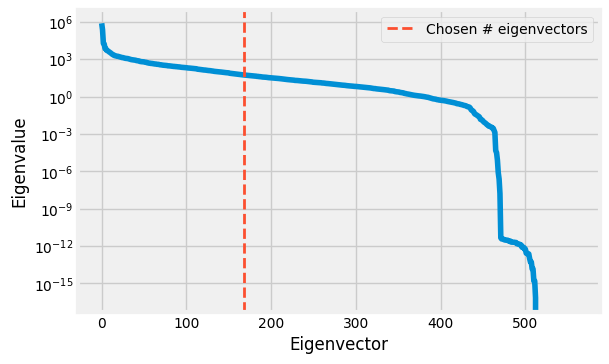

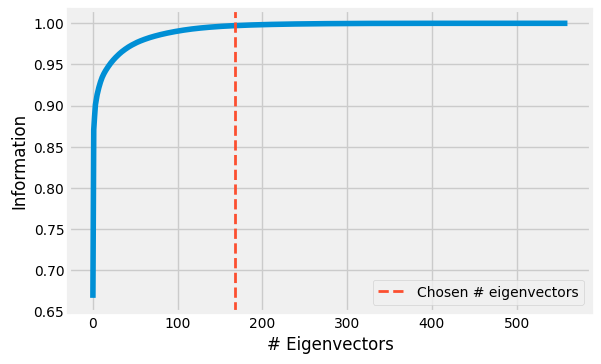

In [11]:
def pca(X: np.ndarray, retain=0.3, verbose=False):
    """
    Performs Principal Component Analysis on X and returns the projected matrix
    :param X: The matrix to perform PCA on
    :param retain: The ratio of features to retain. i.e. 0.1 means project on the top 10% features
    :param verbose: Print and plot additional information
    """

    μ = np.mean(X)
    # Subtract the mean
    Xc = X - μ
    # Compute scatter matrix
    S = Xc.T @ Xc

    eig_vals, eig_vecs = np.linalg.eig(S)
    # The eigenvalues and eigenvectors may have tiny imaginary parts due to numerical errors
    eig_vals, eig_vecs = eig_vals.real, eig_vecs.real

    # Sorting
    idx = eig_vals.argsort()[::-1]
    eig_vals, eig_vecs = eig_vals[idx], eig_vecs[idx]

    # How many eigenvalues to take
    k = int(d * retain)

    if verbose:
        plt.figure()
        plt.plot(np.arange(d), eig_vals)
        plt.axvline(x=k, c="C1", linewidth=2, linestyle="--", label="Chosen # eigenvectors")
        plt.yscale("log")
        plt.xlabel("Eigenvector")
        plt.ylabel("Eigenvalue")
        plt.legend()

        plt.figure()
        plt.plot(np.arange(d), eig_vals.cumsum() / eig_vals.sum())
        plt.axvline(x=k, c="C1", linewidth=2, linestyle="--", label="Chosen # eigenvectors")
        plt.xlabel("# Eigenvectors")
        plt.ylabel("Information")
        plt.legend()

    # Take only the first k eigenvalues
    idx = idx[:k]
    eig_vals, eig_vecs = eig_vals[idx], eig_vecs[idx]

    def project(X):
        return X @ eig_vecs.T

    return project


pca_reduce = pca(train_X, verbose=True)

train_X = pca_reduce(train_X)
_, d = train_X.shape
print(f"After PCA dimensionality reduction, train_X is {n} x {d} dimensional ({n} vectors of {d} features each)")

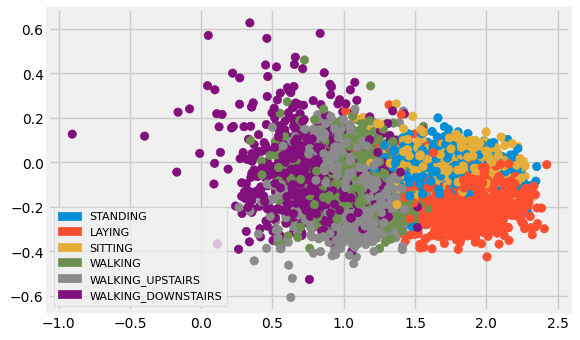

In [14]:
# PCA helps to reduce the number of features but the classes are still not perfectly separable.
# The 3rd and 6th eigenvectors work well together though. Here's a plot:
plt.figure()
scatter = plt.scatter(
    train_X[:, 2],
    train_X[:, 6],
    c=[f"C{y_prime}" for y_prime in train_y],
)
plt.legend(handles=[
    mpatches.Patch(color=f"C{i}", label=label) for i, label in enumerate(cm.from_int)
], prop={'size': 8})